**Klasifikasi Penyakit Kulit (Eksim, Herpes, Kurap, Panu, BlackHead, Milia, Jerawat, Flek Hitam)**




Memasukkan Library yang dibutuhkan

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
data_root = ("/content/gdrive/MyDrive/Capstone_project/Dataset_2.zip") 

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
import tensorflow_hub as hub

In [5]:
print(tf.__version__)

2.12.0


Mengimport Dataset

In [6]:
#Mengekstak file Zip
import zipfile #tambahkan library agar bisa ekstrak zip
local_zip = data_root
extract_zip = zipfile.ZipFile(local_zip, 'r')
extract_zip.extractall('')
extract_zip.close()

In [7]:
!ls Dataset_2/train

Blackhead  Eksim  FlekHitam  Herves  Jerawat  Kurap  Milia  Panu


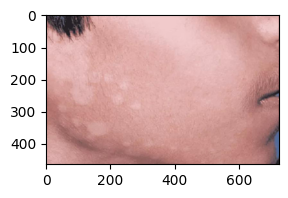

In [8]:

#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread('Dataset_2/train/Panu/panu_1.jpg')
plt.figure(figsize=(3,3))
plt.imshow(image)

In [9]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('Dataset_2/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,    
    vertical_flip = True,
    fill_mode = "nearest")

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

#Memuat dataset pengujian
x_test = []
y_test = []
labels = ['BlackHead', 'Eksim', 'FlekHitam', 'Herpes', 'Jerawat', 'Kurap', 'Milia', 'Panu']

for i,label in enumerate(labels):
  folder = os.path.join('Dataset_2/test', label)
  files = sorted(os.listdir(folder))
  files = [x for x in files if x.endswith(".jpg")]
  for k, file in enumerate(files):
    image_path = os.path.join(folder, file)

    image = imread(image_path)/255.
    image = resize(image, (224, 224))
    x_test.append(image)
    category = os.path.split(folder)[-1]
    y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print('Bentuk array dari dataset train (pelatihan) adalah', image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print('Bentuk array dari dataset validation (validasi) adalah', image_batch.shape,label_batch.shape)
print('Bentuk array dari dataset test (pengujian) adalah', x_test.shape,y_test.shape)

Found 786 images belonging to 8 classes.
Found 193 images belonging to 8 classes.
Bentuk array dari dataset train (pelatihan) adalah (128, 224, 224, 3) (128, 8)
Bentuk array dari dataset validation (validasi) adalah (128, 224, 224, 3) (128, 8)
Bentuk array dari dataset test (pengujian) adalah (39, 224, 224, 3) (39,)


Menyimpan Label

In [10]:
print(train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Blackhead': 0, 'Eksim': 1, 'FlekHitam': 2, 'Herves': 3, 'Jerawat': 4, 'Kurap': 5, 'Milia': 6, 'Panu': 7}


In [11]:
!cat labels.txt

Blackhead
Eksim
FlekHitam
Herves
Jerawat
Kurap
Milia
Panu

Membuat Model dari Jaringan CNN yang sudah dipelajari Sebelumnya (pre-trained convnets)

In [12]:
IMG_SHAPE = (224, 224, 3)
#Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2",
    output_shape=[1000])

#tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              #include_top=False,
                                             #weights='imagenet')
                                              

Feature Extraction

In [13]:
base_model.trainable = False
#base_model.build([None, 224, 224, 3])
#base_model.summary()

Mengelompokkan Klasifikasi 8 Jenis Penyakit Kulit dengan *Deep Learning (CNN)*

In [14]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Mempersiapkan Data Pengujian

In [15]:
y_test2 = to_categorical(y_test)
x_test3, y_test3 = (x_test, y_test2)

In [16]:
model = tf.keras.Sequential([
    base_model, 
    #tf.keras.layers.Conv2D(64, 3, activation='relu'),
    #tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.Dropout(0,2),
    #tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.95):
         print("\nReached 95% accuracy so cancelling training!")
         self.model.stop_training = True

callbacks = myCallback()
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.001),
                metrics=['acc'])

model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              14467622  
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 15,145,390
Trainable params: 677,768
Non-t

Pelatihan

In [18]:
history = model.fit(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=val_generator)

Epoch 1/50
7/7 [==============================] - 186s 25s/step - loss: 1.8703 - acc: 0.3511 - val_loss: 1.4185 - val_acc: 0.4715
Epoch 2/50
7/7 [==============================] - 165s 24s/step - loss: 1.1404 - acc: 0.6145 - val_loss: 1.1152 - val_acc: 0.6373
Epoch 3/50
7/7 [==============================] - 167s 24s/step - loss: 0.8999 - acc: 0.7163 - val_loss: 0.9680 - val_acc: 0.7202
Epoch 4/50
7/7 [==============================] - 153s 22s/step - loss: 0.7495 - acc: 0.7405 - val_loss: 0.9758 - val_acc: 0.6632
Epoch 5/50
7/7 [==============================] - 167s 24s/step - loss: 0.6565 - acc: 0.7799 - val_loss: 0.9994 - val_acc: 0.7098
Epoch 6/50
7/7 [==============================] - 176s 25s/step - loss: 0.5587 - acc: 0.8321 - val_loss: 0.9738 - val_acc: 0.6580
Epoch 7/50
7/7 [==============================] - 168s 24s/step - loss: 0.5320 - acc: 0.8104 - val_loss: 0.8080 - val_acc: 0.7358
Epoch 8/50
7/7 [==============================] - 154s 22s/step - loss: 0.4755 - acc: 0.83

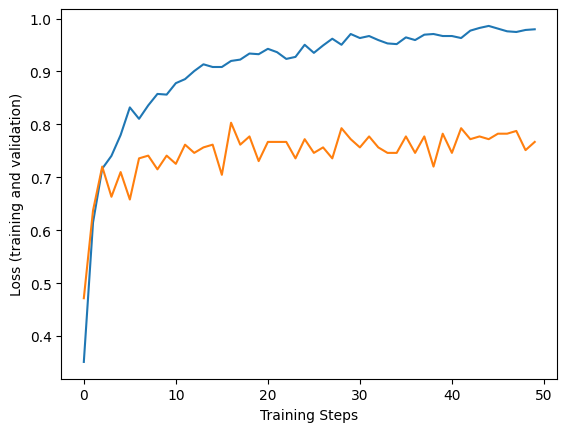

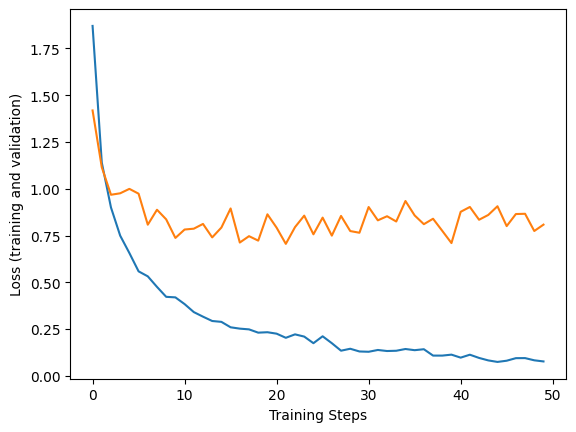

In [19]:
plt.plot(history.history['acc'], label='Akurasi Pelatihan')
plt.plot(history.history['val_acc'], label='Validasi Akurasi')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

plt.plot(history.history['loss'], label='Kesalahan Pelatihan')
plt.plot(history.history['val_loss'], label='Validasi Kesalahan')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [20]:
print("Number of trainable variable = {}".format(len(model.trainable_variables)))

Number of trainable variable = 8


Menggunakan Model

In [21]:
print(train_generator)

In [22]:
#Prediksi Label Validasi dengan Pelatihan
n = 1
input_image = image_batch[n][np.newaxis,...]
print('Labelnya adalah: ', label_batch[n])

predictions = model.predict(input_image)
print('Labelnya adalah: ', predictions[0])

Labelnya adalah:  [0. 1. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 2s 2s/step
Labelnya adalah:  [1.5156766e-11 9.9999511e-01 1.1181321e-10 4.7911676e-06 6.1881742e-08
 4.1857606e-09 1.4968277e-11 1.1363241e-08]


Evaluasi

In [23]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x = x_test3, y=y_test3))

['loss', 'acc']
2/2 [==============================] - 5s 666ms/step - loss: 0.3984 - acc: 0.8718
[0.3983514606952667, 0.8717948794364929]


In [24]:
#Menapilkan matriks yang benad dan matriks hasil prediksi 

#Label yang benar 
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_true)

2/2 [==============================] - 4s 1s/step
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 7 7 7
 7 7]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 7 7 7
 7 7]


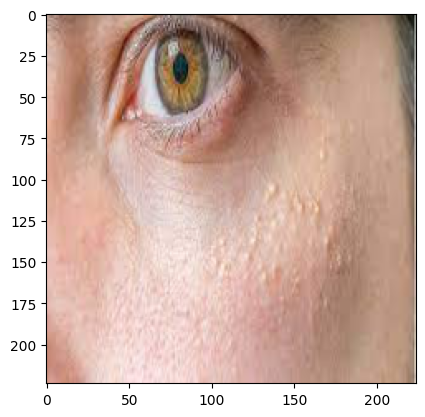

Label yang benar adalah: 6 : Milia
1/1 [==============================] - 0s 233ms/step
Nilai yang diprediksi adalah: [1.2178136e-04 1.3830321e-03 4.3685199e-03 1.1649157e-03 4.7363134e-04
 4.3964174e-05 9.9243695e-01 7.1793766e-06]
Label yang diprediksi adalah: 6 : Milia
Prediksi benar


In [25]:
n = 30 #Jangan melampaui (nilai dari gambar test -1)

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test2, axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print('Label yang diprediksi adalah:', predicted_label, ":", labels[predicted_label])
if true_label == predicted_label:
  print('Prediksi benar')
else:
  print('Prediksi salah')

Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.6 0.4 0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.2 0.2 0.  0.  0.6 0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.2 0.  0.  0.  0.  0.  0.8]]
              precision    recall  f1-score   support

   BlackHead       1.00      1.00      1.00         5
       Eksim       0.71      1.00      0.83         5
   FlekHitam       0.83      1.00      0.91         5
      Herpes       1.00      0.60      0.75         5
     Jerawat       0.71      1.00      0.83         5
       Kurap       1.00      0.60      0.75         5
       Milia       1.00      1.00      1.00         4
        Panu       1.00      0.80      0.89         5

    accuracy                           0.87        39
   macro avg       0.91      0.88      0.87        39
weighted avg       0.91      0.87      0.87        39



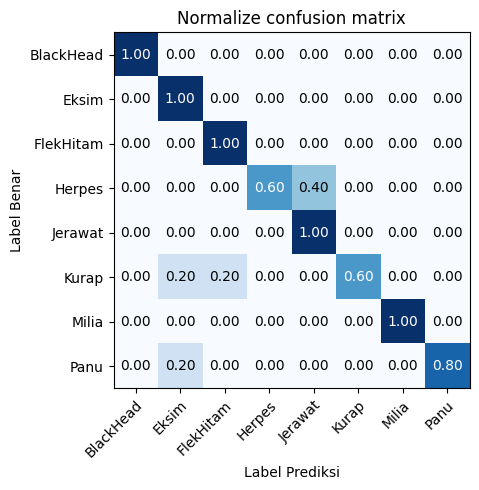

In [26]:
from scipy.interpolate import interpolate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

  if not title:
    if normalize:
      title = "Normalize confusing matrix"
    else:
      title = "Confusing matrix, without normalization"
  
  #Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  #Only use the lables that appear in the data
  #classes = classes[unique_lables(y_true, y_pred)]
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  fig, ax = plt.subplots(figsize=(5,5))
  im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
  #ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         #...and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='Label Benar',
         xlabel='Label Prediksi')

  #Rotate the tick labels and set their alignment
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")
  
  #Loop over data dimension and create text annotation
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt),
              ha = 'center', va = 'center',
              color = 'white' if cm[i,j] > thresh else 'black')
  fig.tight_layout()
  return ax

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalize confusion matrix')

print(classification_report(y_true, y_pred, target_names=labels))

Checking Performance

In [27]:
val_image_batch, val_label_batch = next(iter(val_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (65, 224, 224, 3)


In [28]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Blackhead' 'Eksim' 'Flekhitam' 'Herves' 'Jerawat' 'Kurap' 'Milia' 'Panu']


In [29]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

3/3 [==============================] - 6s 2s/step
Prediction results shape: (65, 8)


In [30]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Eksim' 'Jerawat' 'Eksim' 'Blackhead' 'Panu' 'Eksim' 'Flekhitam'
 'Flekhitam' 'Jerawat' 'Blackhead' 'Jerawat' 'Jerawat' 'Eksim' 'Eksim'
 'Eksim' 'Eksim' 'Flekhitam' 'Flekhitam' 'Flekhitam' 'Blackhead' 'Eksim'
 'Jerawat' 'Eksim' 'Milia' 'Flekhitam' 'Milia' 'Flekhitam' 'Jerawat'
 'Flekhitam' 'Jerawat' 'Jerawat' 'Eksim' 'Milia' 'Blackhead' 'Blackhead'
 'Jerawat' 'Eksim' 'Eksim' 'Eksim' 'Flekhitam' 'Milia' 'Eksim' 'Jerawat'
 'Eksim' 'Panu' 'Panu' 'Jerawat' 'Eksim' 'Milia' 'Jerawat' 'Eksim'
 'Flekhitam' 'Jerawat' 'Milia' 'Kurap' 'Jerawat' 'Eksim' 'Blackhead'
 'Jerawat' 'Eksim' 'Herves' 'Jerawat' 'Jerawat' 'Jerawat' 'Eksim']


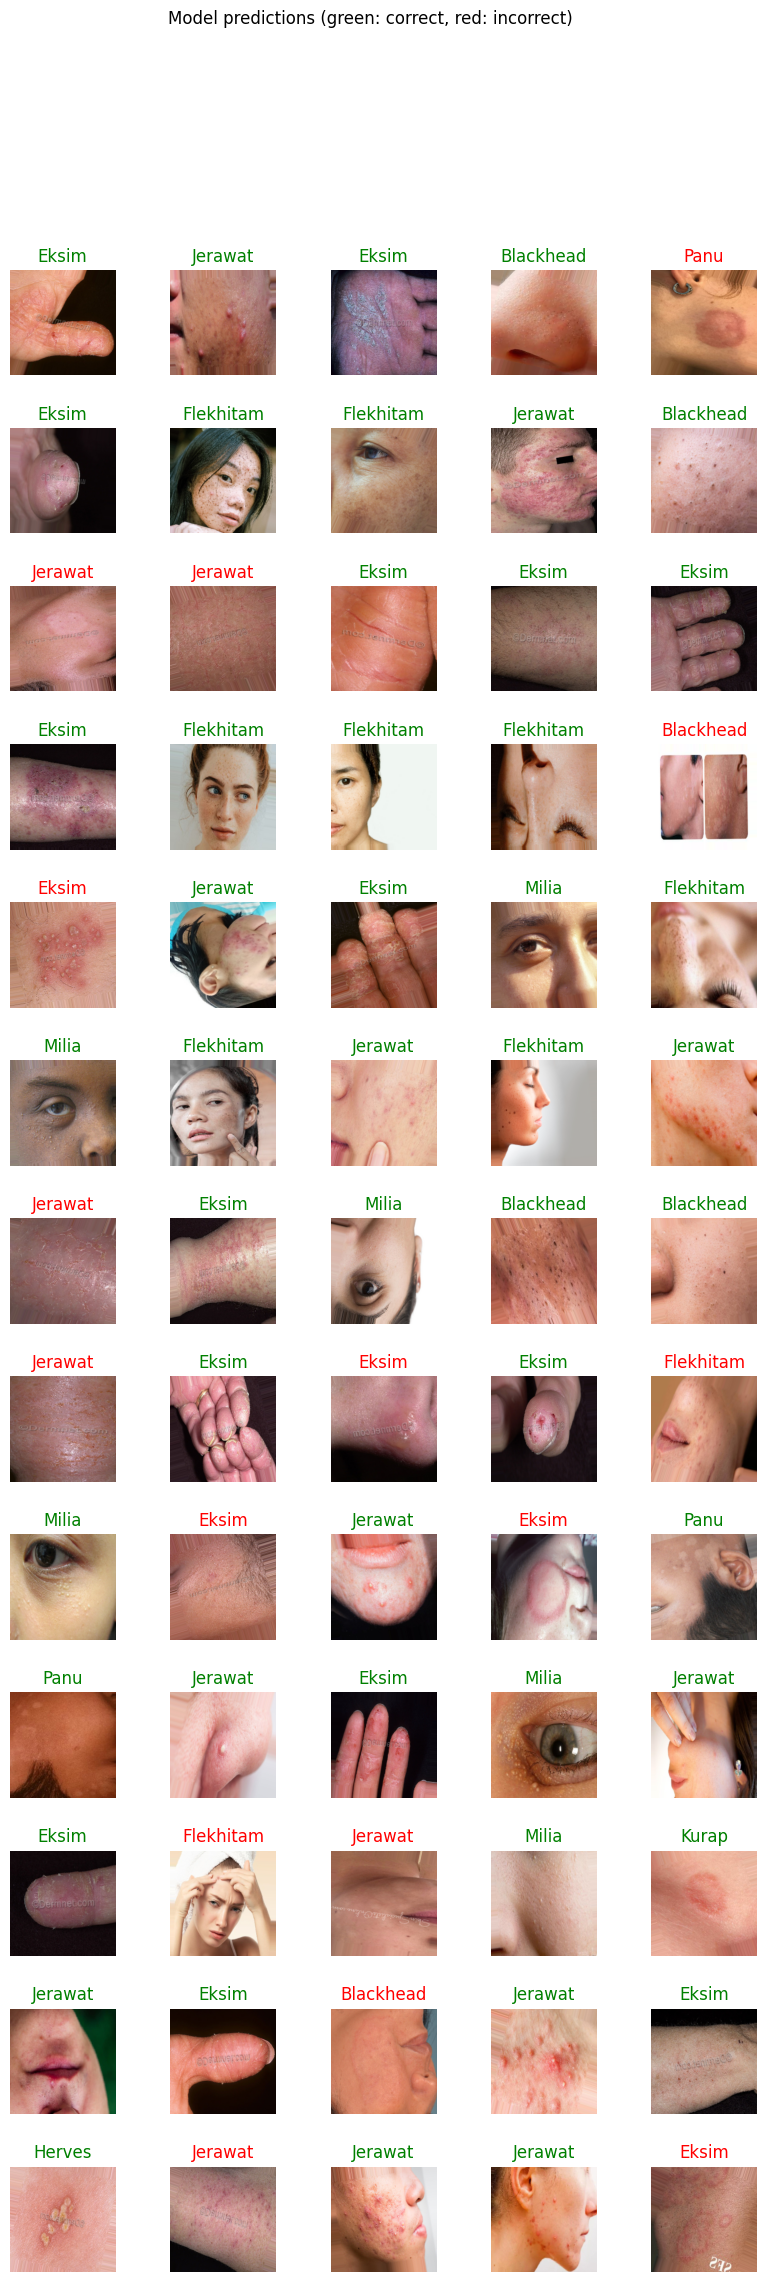

In [31]:
import math

num_images = len(predicted_labels)
rows = math.ceil(num_images / 5)  # Calculate the number of rows needed based on the number of images

plt.figure(figsize=(10, 2 * rows))  # Adjust the figure size based on the number of rows

for n in range(num_images):
    plt.subplot(rows, 5, n+1)  # Create subplots with 5 columns
    plt.imshow(val_image_batch[n])
    color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels[n].title(), color=color)
    plt.axis('off')

plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.subplots_adjust(hspace=0.5)

plt.show()

In [34]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('skinny_2.tflite', 'wb').write(tfmodel)

16299648

In [35]:
model.save('new_model_2.h5')